In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision import datasets, models, transforms
warnings.filterwarnings('ignore')
from PIL import Image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## разделили датасет на выборку для обучения, валидации и тестирования

In [7]:
# считываем датасет, и делим его на выборки для трейн, теста и валида
df = pd.read_csv('/content/drive/MyDrive/2_semestr/PP/2_class.csv')
train_val, test = train_test_split(df, test_size=0.2, random_state=42)

# Разделение тренировочного+валидационного набора на тренировочный и валидационный наборы (75% на 25%)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

In [11]:
def dataset_info(df):
    # Подсчет количества каждого класса
    class_counts = df['класс'].value_counts()
    print(class_counts)
    # Подготовка данных для круговой диаграммы
    labels = ['без болезни', 'ретинопатия']
    sizes = [class_counts[0], class_counts[1]]
    colors = ['#ff9999','#66b3ff']
    explode = (0.1, 0)  # Взрыв первого куска для выделения

    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
    plt.title('Процентное соотношение классов 0 и 1')
    plt.axis('equal')  # Круговая диаграмма выглядит как круг
    plt.show()
    print(len(df))

класс
1    119
0     95
Name: count, dtype: int64


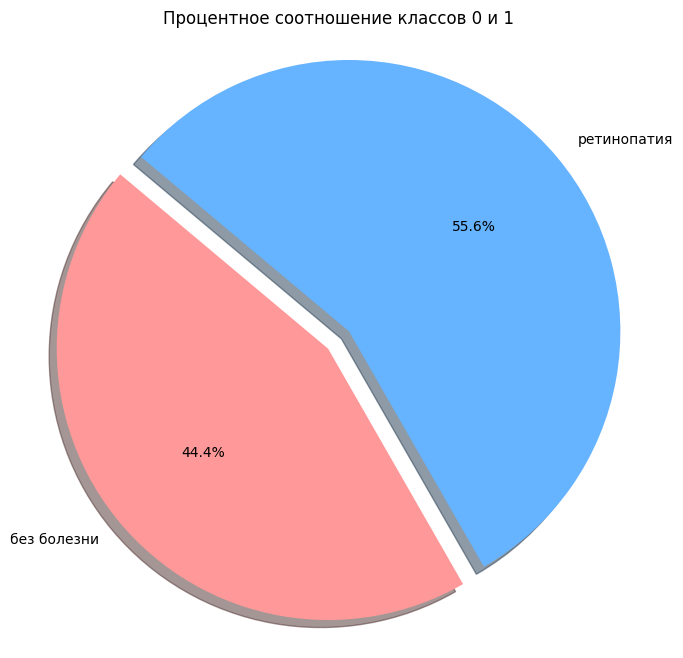

214
класс
1    381
0    259
Name: count, dtype: int64


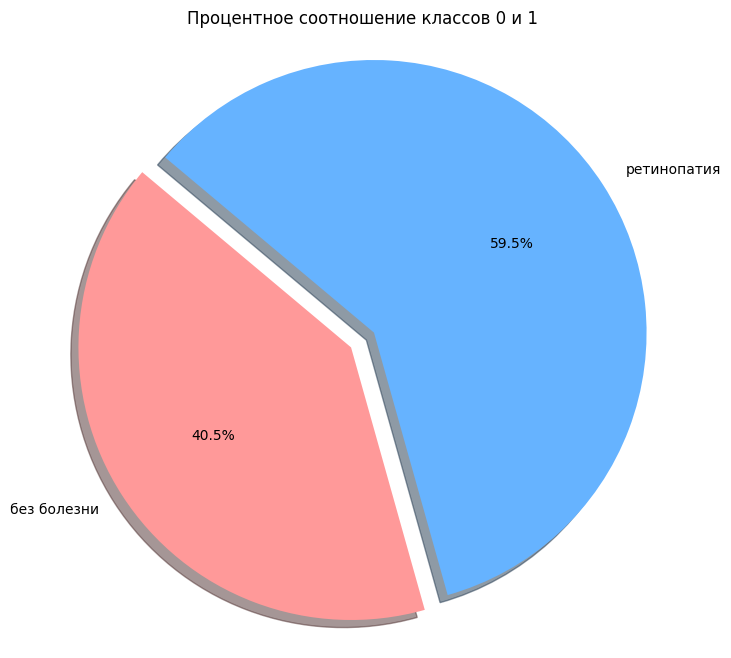

640
класс
1    112
0    102
Name: count, dtype: int64


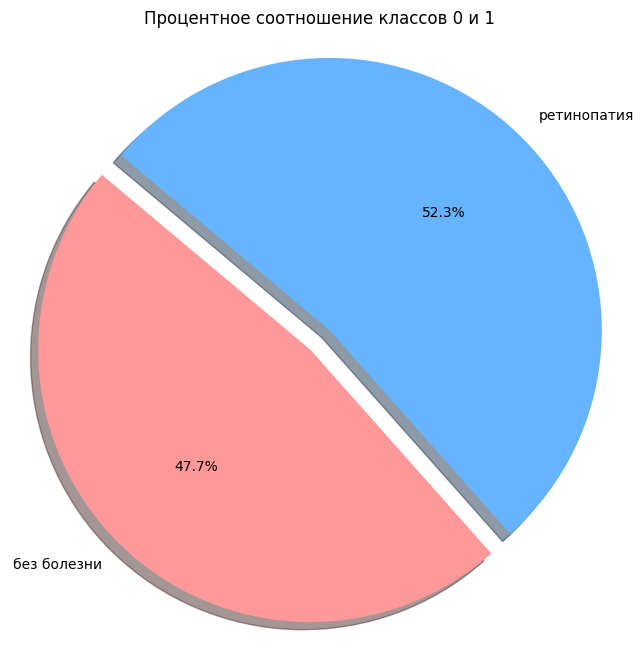

214


In [12]:
dataset_info(test)
dataset_info(train)
dataset_info(val)

In [13]:
# train.to_csv('train_2_class.csv', index = False)
# test.to_csv('test_2_class.csv', index = False)
# val.to_csv('val_2_class.csv', index = False)

## считываем даталоадер

In [34]:
class ROP_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label, img_name

In [59]:
# Трансформации для обучения и валидации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
# Создание объектов датасетов
dataset_train = ROP_Dataset(dataframe=train, image_dir='/content/drive/MyDrive/2_semestr/PP/augmented_images', transform=transform)
dataset_test = ROP_Dataset(dataframe=test, image_dir='/content/drive/MyDrive/2_semestr/PP/augmented_images', transform=transform)
dataset_valid = ROP_Dataset(dataframe=val, image_dir='/content/drive/MyDrive/2_semestr/PP/augmented_images', transform=transform)

In [22]:
# Создание DataLoader для каждого датасета
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

In [24]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of validation examples: {len(dataset_valid)}')
print(f'Number of test examples: {len(dataset_test)}')

Number of training examples: 640
Number of validation examples: 214
Number of test examples: 214


## resnet

In [ ]:
# Загрузка предобученной модели ResNet
model = models.resnet50(pretrained=True)

In [ ]:
# Изменение последнего слоя для бинарной классификации
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)


In [ ]:
# Перемещение модели на GPU, если доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds)
            epoch_rec = recall_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history

In [ ]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)

In [ ]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds)
    test_rec = recall_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds)

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels


In [ ]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)

In [ ]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i][0])}, True: {int(wrong_labels[i][0])}')
        plt.axis('off')
    plt.show()

In [ ]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

Epoch 0/9
----------
train Loss: 0.2809 Acc: 0.8734 Prec: 0.8788 Rec: 0.9134 F1: 0.8958
val Loss: 24.1849 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 1/9
----------
train Loss: 0.0893 Acc: 0.9641 Prec: 0.9661 Rec: 0.9738 F1: 0.9699
val Loss: 1.5863 Acc: 0.6495 Prec: 1.0000 Rec: 0.3304 F1: 0.4966
Epoch 2/9
----------
train Loss: 0.0819 Acc: 0.9719 Prec: 0.9739 Rec: 0.9790 F1: 0.9764
val Loss: 73.7366 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 3/9
----------
train Loss: 0.1936 Acc: 0.9594 Prec: 0.9733 Rec: 0.9580 F1: 0.9656
val Loss: 36.4151 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 4/9
----------
train Loss: 0.1143 Acc: 0.9609 Prec: 0.9588 Rec: 0.9764 F1: 0.9675
val Loss: 0.1210 Acc: 0.9486 Prec: 0.9810 Rec: 0.9196 F1: 0.9493
Epoch 5/9
----------
train Loss: 0.0992 Acc: 0.9578 Prec: 0.9634 Rec: 0.9659 F1: 0.9646
val Loss: 0.1867 Acc: 0.9019 Prec: 1.0000 Rec: 0.8125 F1: 0.8966
Epoch 6/9
----------
train Loss: 0.0732 Acc: 0.9734 Prec: 0.9764 Rec: 0.9790 F1

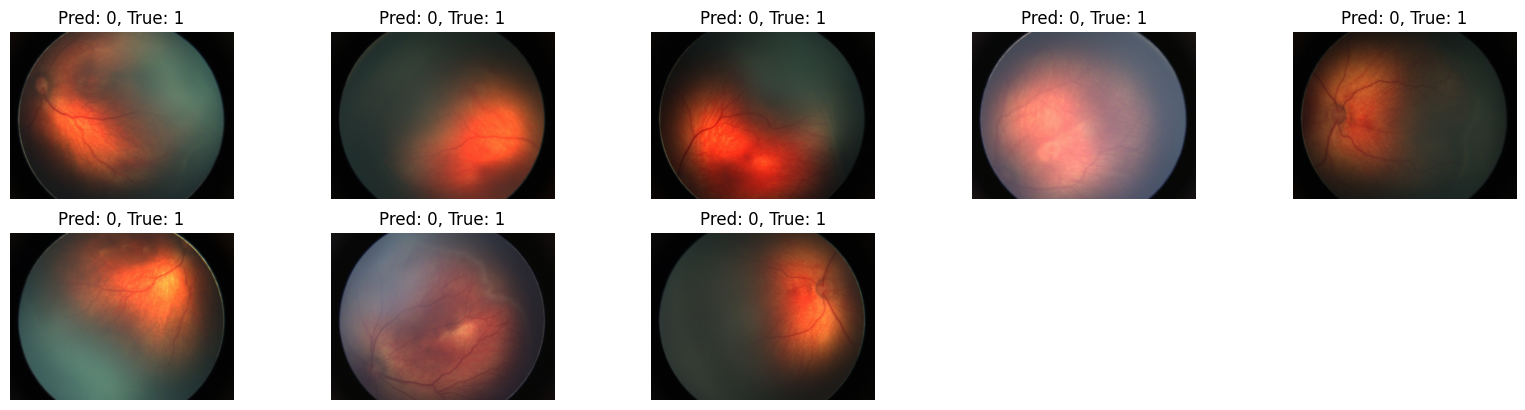

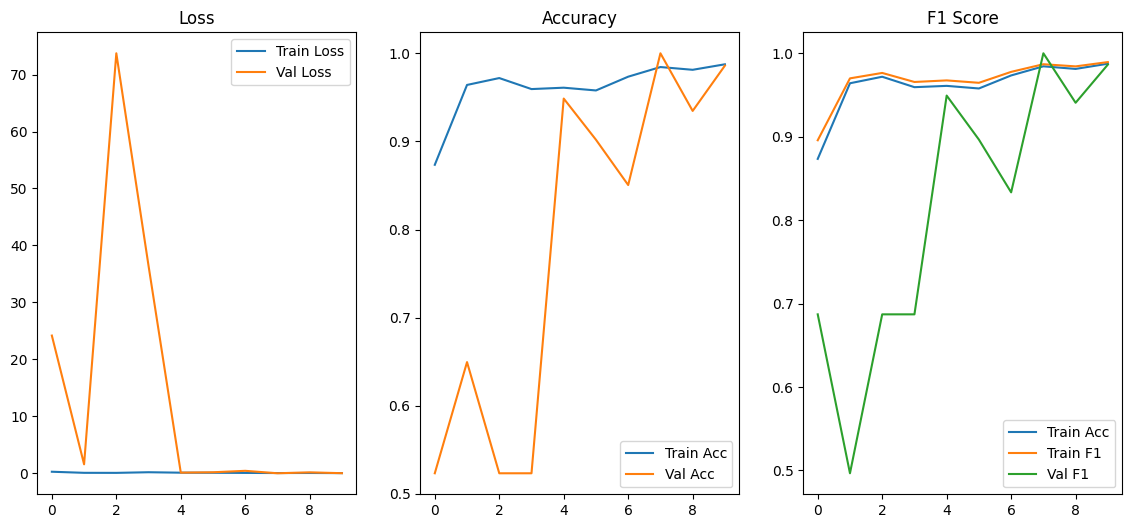

In [37]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

# Визуализация графиков
plot_history(history)

## effectivenet

In [38]:
# Загрузка предобученной модели EfficientNet
model = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.2MB/s]


In [39]:
# Изменение последнего слоя для бинарной классификации
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)

In [40]:
# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds)
            epoch_rec = recall_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history


In [43]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.1639 Acc: 0.9437 Prec: 0.9551 Rec: 0.9501 F1: 0.9526
val Loss: 5.1557 Acc: 0.5280 Prec: 0.5258 Rec: 1.0000 F1: 0.6892
Epoch 1/9
----------
train Loss: 0.0964 Acc: 0.9703 Prec: 0.9714 Rec: 0.9790 F1: 0.9752
val Loss: 0.0212 Acc: 0.9907 Prec: 0.9825 Rec: 1.0000 F1: 0.9912
Epoch 2/9
----------
train Loss: 0.0204 Acc: 0.9922 Prec: 0.9974 Rec: 0.9895 F1: 0.9934
val Loss: 0.0047 Acc: 0.9953 Prec: 0.9912 Rec: 1.0000 F1: 0.9956
Epoch 3/9
----------
train Loss: 0.0071 Acc: 0.9969 Prec: 0.9974 Rec: 0.9974 F1: 0.9974
val Loss: 0.0035 Acc: 1.0000 Prec: 1.0000 Rec: 1.0000 F1: 1.0000
Epoch 4/9
----------
train Loss: 0.0086 Acc: 0.9969 Prec: 0.9974 Rec: 0.9974 F1: 0.9974
val Loss: 0.0513 Acc: 0.9766 Prec: 0.9908 Rec: 0.9643 F1: 0.9774
Epoch 5/9
----------
train Loss: 0.0260 Acc: 0.9938 Prec: 0.9948 Rec: 0.9948 F1: 0.9948
val Loss: 0.0043 Acc: 1.0000 Prec: 1.0000 Rec: 1.0000 F1: 1.0000
Epoch 6/9
----------
train Loss: 0.0174 Acc: 0.9969 Prec: 0.9974 Rec: 0.9974 F1: 0

In [45]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds)
    test_rec = recall_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds)

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels

In [46]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)


Test Accuracy: 1.0000 Prec: 1.0000 Rec: 1.0000 F1: 1.0000


In [47]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i][0])}, True: {int(wrong_labels[i][0])}')
        plt.axis('off')
    plt.show()

In [48]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

<Figure size 2000x1000 with 0 Axes>

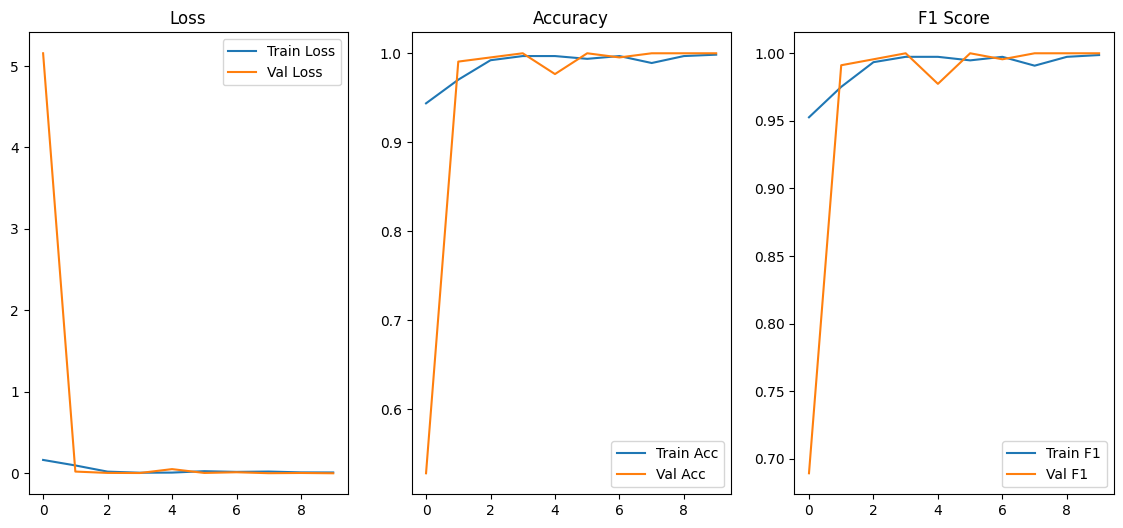

In [49]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

plot_history(history)

## DenseNet121

In [60]:
# Загрузка предобученной модели DenseNet121
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 51.1MB/s]


In [61]:
# Изменение последнего слоя для бинарной классификации
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)


In [62]:
# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:

# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds)
            epoch_rec = recall_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history

In [64]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2176 Acc: 0.8969 Prec: 0.9223 Rec: 0.9029 F1: 0.9125
val Loss: 0.0861 Acc: 0.9720 Prec: 0.9569 Rec: 0.9911 F1: 0.9737
Epoch 1/9
----------
train Loss: 0.1028 Acc: 0.9625 Prec: 0.9760 Rec: 0.9606 F1: 0.9683
val Loss: 7.7100 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 2/9
----------
train Loss: 0.1189 Acc: 0.9563 Prec: 0.9633 Rec: 0.9633 F1: 0.9633
val Loss: 5.0584 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 3/9
----------
train Loss: 0.0848 Acc: 0.9734 Prec: 0.9789 Rec: 0.9764 F1: 0.9777
val Loss: 0.4105 Acc: 0.8364 Prec: 1.0000 Rec: 0.6875 F1: 0.8148
Epoch 4/9
----------
train Loss: 0.0489 Acc: 0.9859 Prec: 0.9921 Rec: 0.9843 F1: 0.9881
val Loss: 23.9153 Acc: 0.5234 Prec: 0.5234 Rec: 1.0000 F1: 0.6871
Epoch 5/9
----------
train Loss: 0.0595 Acc: 0.9750 Prec: 0.9815 Rec: 0.9764 F1: 0.9789
val Loss: 1.0746 Acc: 0.6776 Prec: 1.0000 Rec: 0.3839 F1: 0.5548
Epoch 6/9
----------
train Loss: 0.0756 Acc: 0.9766 Prec: 0.9816 Rec: 0.9790 F1: 

In [65]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds)
    test_rec = recall_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds)

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels

In [66]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)

Test Accuracy: 0.9673 Prec: 1.0000 Rec: 0.9412 F1: 0.9697


In [67]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i][0])}, True: {int(wrong_labels[i][0])}')
        plt.axis('off')
    plt.show()

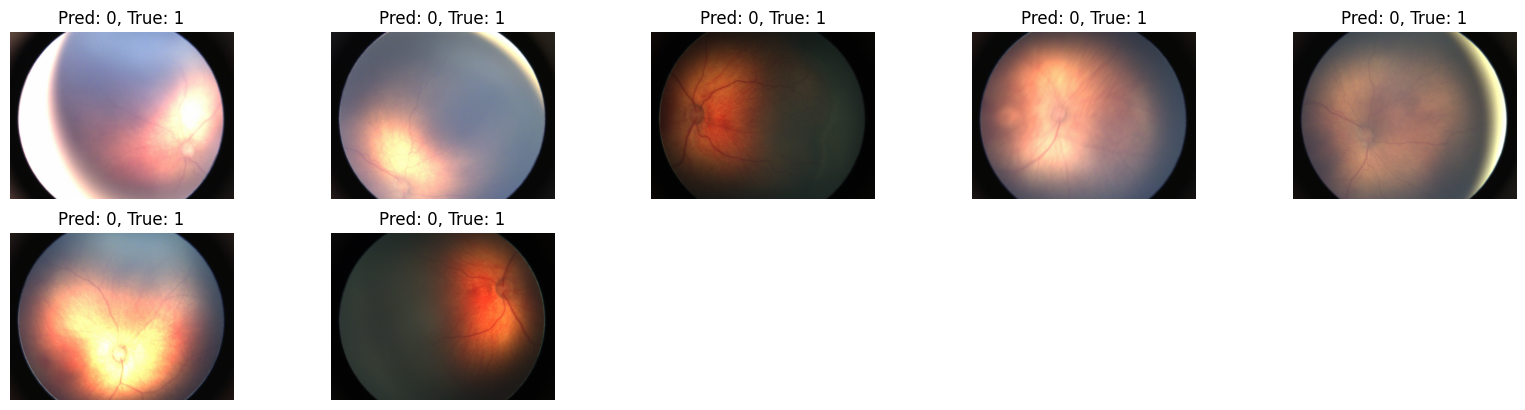

In [68]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

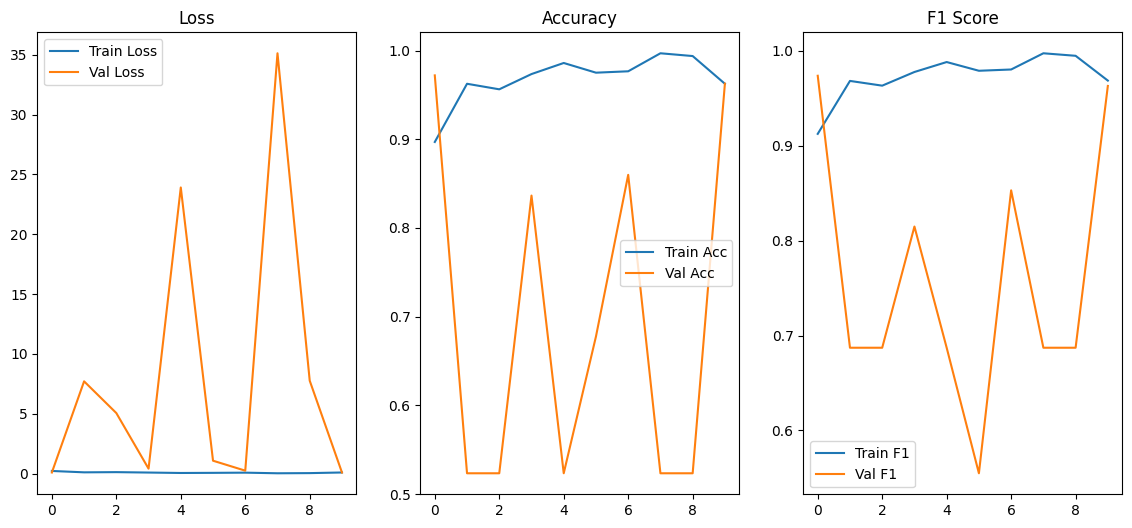

In [69]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

plot_history(history)